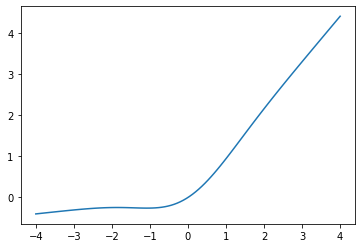

In [39]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F


x = torch.linspace(-4, 4, 100)
y = F.gelu(x) + 0.1 * x

# alpha = 0.1
# z = torch.where(x > 0, x * (x + alpha), alpha * (torch.exp(x) - 1))


# def hardswish(x, a=2):
#     y = torch.where(x < -a, -a, x)
#     y = torch.where(y > a, a, y)
#     return x * (y + a) / 2 / a

# # z = hardswish(x)

plt.plot(x, y, label="gelu")
# plt.plot(x, z, label="srelu")
plt.show()



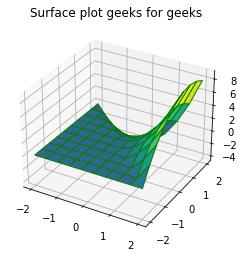

In [24]:
import numpy as np
import matplotlib.pyplot as plt
 
def relu(x):
    return np.maximum(0, x)


def relu2(x):
    # `a` is the bias from the previous layer
    a, b, c, d = 1, 1, 1, 0
    return c * (np.maximum(0, x + a) - b) ** 2 - d


# defining surface and axes
x = np.outer(np.linspace(-2, 2, 10), np.ones(10))
y = x.copy().T

# 1-order cannot express
z = relu((2 * x - y) * (x + y))
# z = relu((x - y)) * (x + y)
# z = x ** 2 - y ** 2

# both can express
# z = relu((x) * (x))
# z = relu(x) + relu(-x)

# 2-order cannot express
# z = (x + y + 2) * (relu(x + y + 2))
# z = (x + y + 3) * (x + y + 3)
# z = relu((x + y + 2) * (x + y + 2))
# z = relu(x) + relu(y)
# z = relu(x) ** 2 + relu(y) ** 2

# z = relu2(x + .1 * y) - relu2(y + .1 * x)
# z = relu(x) - relu(y)

fig = plt.figure()

# syntax for 3-D plotting
ax = plt.axes(projection ='3d')

# syntax for plotting
ax.plot_surface(x, y, z, cmap ='viridis', edgecolor ='green')
ax.set_title('Surface plot geeks for geeks')
plt.show()

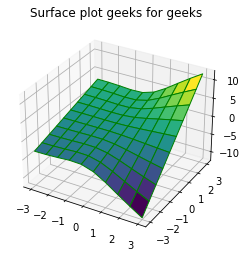

In [53]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


def relu(x):
    return np.maximum(0, x)

def hardswish(x, a=2):
    y = np.where(x < -a, -a, x)
    y = np.where(y > a, a, y)
    return x * (y + a) / 2 / a

def gelu(x):
    return F.gelu(torch.tensor(x)).numpy()

def squaredelu(x, a=1):
    return np.where(x > 0, x * (x + a), a * (np.exp(x) - 1))


# defining surface and axes
x = np.outer(np.linspace(-3, 3, 20), np.ones(20))
y = x.copy().T

# z = relu(x) * y
# z = hardswish(x) * y
# z = gelu(x) * y * y
# z = squaredelu(x) * y

# z = gelu(x) - gelu(y)
# z = (0.5 * gelu(x) - 0 * gelu(-x)) * y
z = (gelu(x) - 1 * x) * y

fig = plt.figure()

# syntax for 3-D plotting
ax = plt.axes(projection ='3d')

# syntax for plotting
ax.plot_surface(x, y, z, cmap ='viridis', edgecolor ='green')
ax.set_title('Surface plot geeks for geeks')
plt.show()

In [47]:
F.gelu(torch.tensor(-6.))

tensor(-0.)